# Summary
This notebook contains an exploration of a spatial subset of the GSOD station list. The full list was filtered for locations within WIEB's member states before loading here.

Highlights & notes:
* all priority cities have at least one station with a *nominal* data period going back to 1950s, with most going back to the 1940s.
* neither usaf nor wban fields are candidate ID keys. I think they'll have to be combined into a compound key.
* many weather stations are split into multiple entries in the station list with disjoint time periods. We might be able to concatenate them?
* after filtering for <=50km distance from a priority city and >=10 year data period, there are still >200 stations
* Billings and Albequerque have the fewest candidate staions, with only 2 each.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
station_list_subset_path = Path('../data/raw/all_gsod_stations_in_wieb_territory.csv')
assert station_list_subset_path.exists()

In [3]:
gsod = pd.read_csv(station_list_subset_path, parse_dates=[-1, -2])

In [4]:
gsod.head(3)

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,690014,99999,C STN WHITE SANDS,US,NM,NaN,32.35,-106.367,1224.0,1987-01-01,1991-06-11
1,690020,93218,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36.00,-121.233,317.0,1964-07-15,1997-04-01
2,690020,99999,JOLON HUNTER LIGGETT MIL RES,US,CA,KHGT,36.00,-121.233,317.0,2003-07-02,2003-08-01


In [5]:
gsod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2238 entries, 0 to 2237
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   usaf     2238 non-null   object        
 1   wban     2238 non-null   int64         
 2   name     2237 non-null   object        
 3   country  2238 non-null   object        
 4   state    1593 non-null   object        
 5   call     1484 non-null   object        
 6   lat      2236 non-null   float64       
 7   lon      2236 non-null   float64       
 8   elev     2233 non-null   float64       
 9   begin    2238 non-null   datetime64[ns]
 10  end      2238 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(5)
memory usage: 192.5+ KB


In [6]:
raw_cols = list(gsod.columns)

In [7]:
gsod['duration_years'] = gsod['end'].sub(gsod['begin']).dt.total_seconds() / 60 / 60 / 24 / 365.25

<AxesSubplot:>

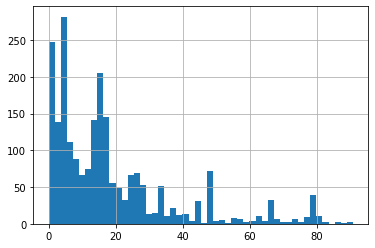

In [8]:
gsod['duration_years'].hist(bins=50)

In [9]:
priority_cities_path = Path('../data/processed/priority_cities.csv')
assert priority_cities_path.exists()

In [10]:
cities = pd.read_csv(priority_cities_path)
cities.head(2)

,city,state/province,country,latitude,longitude
0,Phoenix,Arizona,USA,33.448377,-112.074038
1,Tucson,Arizona,USA,32.222607,-110.974711


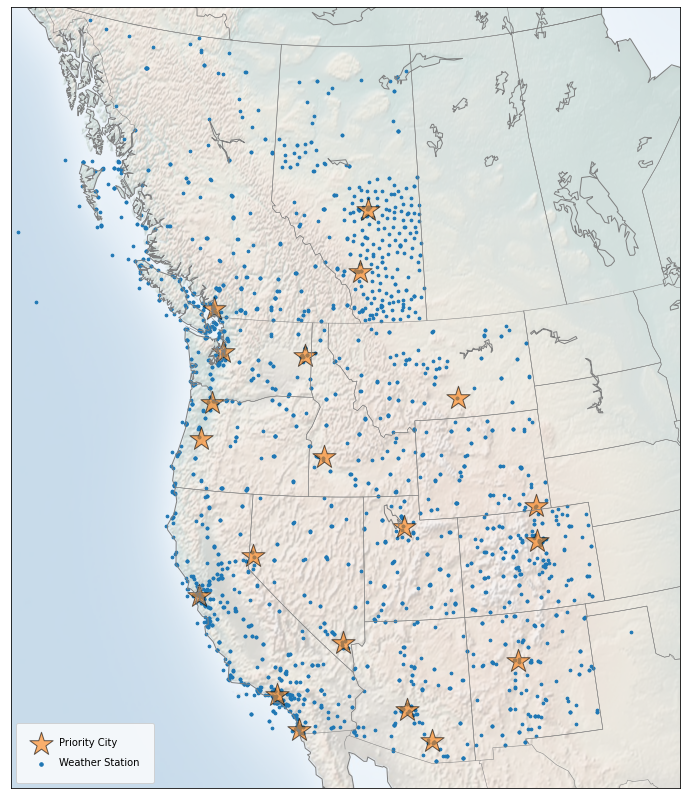

In [65]:
fig = plt.figure(figsize=(12, 15))
m = Basemap(projection='lcc', resolution='l',
            lon_0=-115.0, lat_0=46.0,
            width=3e6, height=3.5e6
           )
m.shadedrelief(alpha=0.4)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(gsod.loc[:, 'lon'], gsod.loc[:, 'lat'], latlon=True, marker='.', c='tab:blue', s=30)
m.scatter(cities['longitude'], cities['latitude'], latlon=True, marker='*', c='tab:orange', s=600, edgecolors='black', alpha=0.6)
#m.scatter(to_export['lon'], to_export['lat'], latlon=True, marker='.', c='tab:red', edgecolors='white', s=100, alpha=0.8)

# legend
plt.scatter([], [], marker='*', c='tab:orange', s=600, edgecolors='black', alpha=0.6, label='Priority City')
plt.scatter([], [], marker='.', c='tab:blue', s=50, label='Weather Station')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='lower left', borderpad=1.5)

# Spatial Subset to Cities

In [12]:
# haversine distance gives angular distance between two points on a sphere.
# Convert to arc length by multiplying by earth's radius
from sklearn.metrics.pairwise import haversine_distances

In [13]:
def degrees_to_radians(df):
    return df * (np.pi / 180.0)

In [14]:
earth_radius_km = 6371 # wikipedia

In [15]:
distance_matrix = haversine_distances(degrees_to_radians(gsod[['lat', 'lon']]), degrees_to_radians(cities[['latitude', 'longitude']])) * earth_radius_km

In [16]:
distance_matrix.shape

(2238, 20)

In [17]:
distance_cols = [f"{city.lower().replace(' ', '_')}_km" for city in cities['city']]
distance_matrix = pd.DataFrame(distance_matrix, columns=distance_cols, index=gsod.index)
distance_matrix.head(3)

,phoenix_km,tucson_km,los_angeles_km,san_francisco_km,san_diego_km,denver_km,boise_km,billings_km,las_vegas_km,reno_km,albuquerque_km,portland_km,eugene_km,salt_lake_city_km,seattle_km,spokane_km,cheyenne_km,calgary_km,edmonton_km,vancouver_km
0,546.559638,433.336867,1120.455030,1577.939331,1012.287475,830.883682,1518.093747,1504.874148,910.746862,1447.659322,305.177281,2025.412076,1949.513957,1056.832724,2165.467421,1940.956450,987.019189,2172.056748,2424.318807,2340.866304
1,883.396160,1032.873404,347.815125,223.792281,522.462454,1482.730754,949.083860,1522.421972,547.777696,411.827666,1322.083836,1064.974565,909.085151,970.392430,1293.725591,1333.773333,1534.029061,1767.661596,2041.540681,1484.893256
2,883.396160,1032.873404,347.815125,223.792281,522.462454,1482.730754,949.083860,1522.421972,547.777696,411.827666,1322.083836,1064.974565,909.085151,970.392430,1293.725591,1333.773333,1534.029061,1767.661596,2041.540681,1484.893256


In [18]:
gsod = pd.concat([gsod, distance_matrix], axis=1, copy=False)

In [19]:
gsod.columns

Index(['usaf', 'wban', 'name', 'country', 'state', 'call', 'lat', 'lon',
       'elev', 'begin', 'end', 'duration_years', 'phoenix_km', 'tucson_km',
       'los_angeles_km', 'san_francisco_km', 'san_diego_km', 'denver_km',
       'boise_km', 'billings_km', 'las_vegas_km', 'reno_km', 'albuquerque_km',
       'portland_km', 'eugene_km', 'salt_lake_city_km', 'seattle_km',
       'spokane_km', 'cheyenne_km', 'calgary_km', 'edmonton_km',
       'vancouver_km'],
      dtype='object')

In [20]:
gsod['is_close_to_city'] = gsod[distance_cols].lt(50).any(axis=1)

In [21]:
one_hot_cols = [f"{col.rsplit('_', maxsplit=1)[0]}_close" for col in distance_cols]

In [22]:
gsod = pd.concat([
    gsod,
    gsod[distance_cols].le(50).rename(columns=dict(zip(distance_cols, one_hot_cols)))
                 ],
                 copy=False,
                 axis=1,
                )

In [23]:
gsod.loc[gsod['phoenix_close'], raw_cols]

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
86,722785,99999,LUKE AFB,US,AZ,KLUF,33.533,-112.383,331.0,2000-01-03,2004-12-29
554,999999,53156,PHOENIX 7 S,US,AZ,NaN,33.347,-112.083,427.9,2010-03-01,2014-06-01
576,999999,93105,LITCHFIELD PARK NAF,US,AZ,NaN,33.433,-112.367,292.0,1948-04-01,1966-09-29
698,999999,23183,PHOENIX SKY HARBOR INTL AP,US,AZ,KPHX,33.428,-112.004,337.4,1948-01-01,1972-12-31
764,722786,99999,WILLIAMS GATEWAY,US,AZ,KIWA,33.300,-111.650,421.0,2000-01-01,2003-12-31
870,722749,99999,CHANDLER MUNI,US,AZ,KCHD,33.267,-111.817,379.0,1999-01-14,2005-12-31
872,722783,99999,MESA/FALCON FIELD,US,AZ,KFFZ,33.467,-111.733,424.0,1988-01-05,2005-12-31
873,722784,99999,PHOENIX DEER VALLEY,US,AZ,KDVT,33.688,-112.083,450.0,1987-06-29,2005-12-31
874,722787,99999,GLENDALE MUNI,US,AZ,KGEU,33.527,-112.295,325.0,1999-01-14,2005-12-31
875,722788,99999,PHOENIX GOODYEAR,US,AZ,KGYR,33.417,-112.383,295.0,1987-06-03,2005-12-31


# Temporal Analysis


In [24]:
candidates = gsod.loc[gsod['phoenix_close'] & gsod['duration_years'].ge(10), raw_cols]
candidates

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
576,999999,93105,LITCHFIELD PARK NAF,US,AZ,NaN,33.433,-112.367,292.0,1948-04-01,1966-09-29
698,999999,23183,PHOENIX SKY HARBOR INTL AP,US,AZ,KPHX,33.428,-112.004,337.4,1948-01-01,1972-12-31
872,722783,99999,MESA/FALCON FIELD,US,AZ,KFFZ,33.467,-111.733,424.0,1988-01-05,2005-12-31
873,722784,99999,PHOENIX DEER VALLEY,US,AZ,KDVT,33.688,-112.083,450.0,1987-06-29,2005-12-31
875,722788,99999,PHOENIX GOODYEAR,US,AZ,KGYR,33.417,-112.383,295.0,1987-06-03,2005-12-31
876,722789,99999,SCOTTSDALE,US,AZ,KSDL,33.623,-111.911,460.0,1987-06-29,2005-12-31
1243,722749,53128,CHANDLER MUNICIPAL AIRPORT,US,AZ,KCHD,33.269,-111.813,378.9,2006-01-01,2021-09-21
1245,722780,23183,PHOENIX SKY HARBOR INTL AIRPO,US,AZ,KPHX,33.428,-112.004,337.4,1973-01-01,2021-09-21
1246,722783,3185,FALCON FIELD AIRPORT,US,AZ,KFFZ,33.467,-111.733,420.6,2006-01-01,2021-09-21
1247,722784,3184,PHOENIX DEER VALLEY ARPT,US,AZ,KDVT,33.688,-112.082,443.5,2006-01-01,2021-09-21


In [25]:
timeseries = pd.date_range(start=candidates['begin'].min(), end=candidates['end'].max(), freq='MS')

In [26]:
timeseries

DatetimeIndex(['1941-12-01', '1942-01-01', '1942-02-01', '1942-03-01',
               '1942-04-01', '1942-05-01', '1942-06-01', '1942-07-01',
               '1942-08-01', '1942-09-01',
               ...
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01'],
              dtype='datetime64[ns]', length=958, freq='MS')

In [27]:
counts = pd.Series(0, index=timeseries, name='station_count')

In [28]:
for row in candidates.iterrows():
    counts.loc[row[1]['begin']: row[1]['end']] += 1

In [29]:
counts

1941-12-01    1
1942-01-01    1
1942-02-01    1
1942-03-01    2
1942-04-01    2
             ..
2021-05-01    9
2021-06-01    9
2021-07-01    9
2021-08-01    9
2021-09-01    9
Freq: MS, Name: station_count, Length: 958, dtype: int64

<AxesSubplot:>

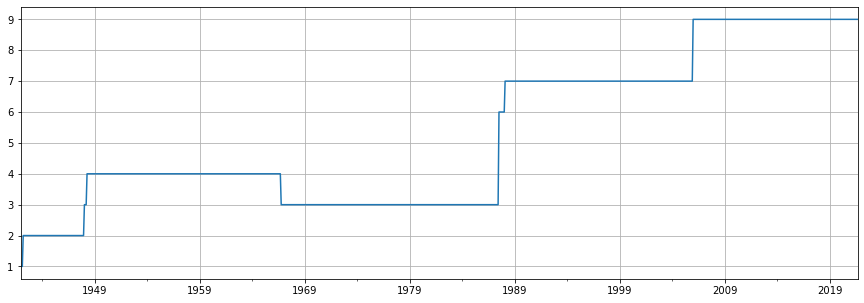

In [30]:
counts.plot(figsize=(15,5), grid=True)

In [32]:
alt.Chart(candidates).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title='Phoenix'
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [33]:
city_names = iter(cities['city'].str.lower().str.replace(' ', '_').to_list())

In [34]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [35]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [36]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [37]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [38]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [39]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [40]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [41]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [42]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [43]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [44]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [45]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [46]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [47]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [48]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [49]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [50]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [51]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [52]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [53]:
name = next(city_names)
subset = gsod.loc[gsod[f'{name}_close'] & gsod['duration_years'].ge(10), raw_cols]
alt.Chart(subset).mark_bar().encode(
    alt.X('begin:T'),
    alt.X2('end:T'),
    alt.Y('name:N')
).properties(
    title=name
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

alt.Chart(...)

In [54]:
to_export = gsod.loc[gsod['is_close_to_city'] & gsod['duration_years'].ge(10), raw_cols + ['duration_years']]
to_export.shape

(235, 12)

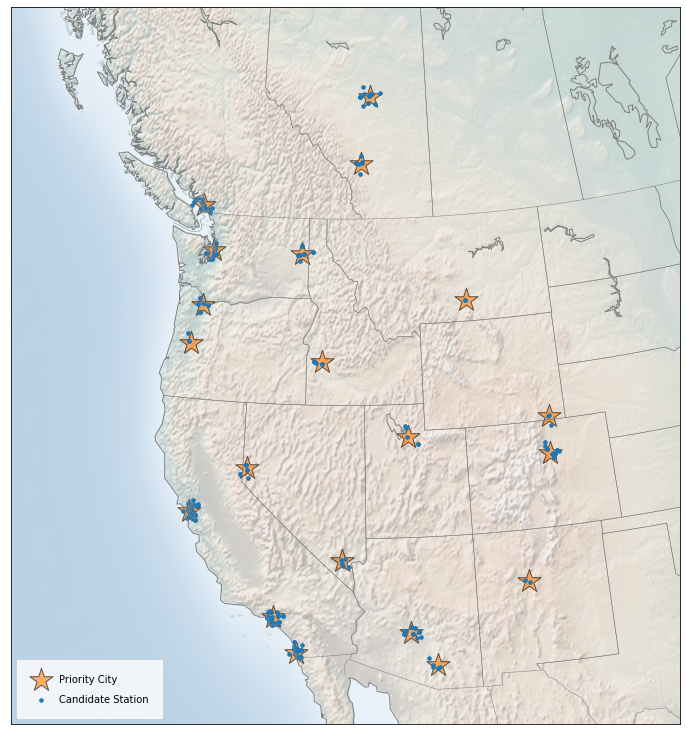

In [63]:
fig = plt.figure(figsize=(12, 15))
m = Basemap(projection='lcc', resolution='l',
            lon_0=-115.0, lat_0=43.5,
            width=2.8e6, height=3e6
           )
m.shadedrelief(alpha=0.5)
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
m.scatter(cities['longitude'], cities['latitude'], latlon=True, marker='*', c='tab:orange', s=600, edgecolors='black', alpha=0.6)
m.scatter(to_export['lon'], to_export['lat'], latlon=True, marker='.', c='tab:blue', s=50)

# legend
plt.scatter([], [], marker='*', c='tab:orange', s=600, edgecolors='black', alpha=0.6, label='Priority City')
plt.scatter([], [], marker='.', c='tab:blue', s=50, label='Candidate Station')
plt.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='lower left', borderpad=1.5)

In [56]:
priority_cities_path.parent

PosixPath('../data/processed')

In [57]:
assert False # stop "run all cells" from overwriting files

AssertionError: 

In [59]:
to_export.loc[:, 'duration_years'] = to_export.loc[:, 'duration_years'].round(2)

In [60]:
to_export.to_csv(priority_cities_path.parent / "candidate_stations_50km_10yr.csv", index=False)